# Finding Donors for CharityML

In this project I'm going to employ several supervised algorithms to accurately model individual's income using data collected from the 1994 U.S. Census. Then I'm going to choose the best candidate algorithm from preliminary results and further optimize this algorithm to best model the data. The goal is to construct a model that accurately predicts whether and individual makes more than $50,000. Understanding an individual's income can help a non-profit better understand how large of a donation to request, or whether or not they should reach out to begin with. 

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income).

## Explore the Data

The last column in the dataset,`'income'`, is the target label (whether an individual makes more than, or at most, $50,000 annually). All other columns are features about each individual in the census database.

In [1]:
# import libraries necessary for this project
import numpy as np
import pandas as pd
from time import time
import seaborn as sn
from IPython.display import display

# import supplementary visualization code visuals.py
import visuals as vs

# display for notebooks
%matplotlib inline

# load the Census dataset
data = pd.read_csv('census.csv')

# display first row
display(data.head(1))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K


In [2]:
# total number of records
n_records = data.shape[0]

# number of records where individual's income is more than $50,000
n_greater_50k = data.query('income == ">50K"').shape[0]

# number of records where individual's income is at most $50,000
n_at_most_50k = data.query('income == "<=50K"').shape[0]

# percentage of individuals whose income is more than $50,000
greater_percent = (n_greater_50k/n_records)*100

# print results
print("Total number of records: {}".format(n_records))
print("Individuals making more than $50,000: {}".format(n_greater_50k))
print("Individuals making at most $50,000: {}".format(n_at_most_50k))
print("Percentage of individuals making more than $50,000: {}%".format(greater_percent))

Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.78439697492371%


The dataset is unbalanced. There're less records where individuals make more than $50,000.

**Feature Exploration**

* **age**: continuous. 
* **workclass**: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked. 
* **education**: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool. 
* **education-num**: continuous. 
* **marital-status**: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse. 
* **occupation**: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces. 
* **relationship**: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried. 
* **race**: Black, White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other. 
* **sex**: Female, Male. 
* **capital-gain**: continuous. 
* **capital-loss**: continuous. 
* **hours-per-week**: continuous. 
* **native-country**: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

/Users/dmitrykrasnikov/anaconda3/envs/ds/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


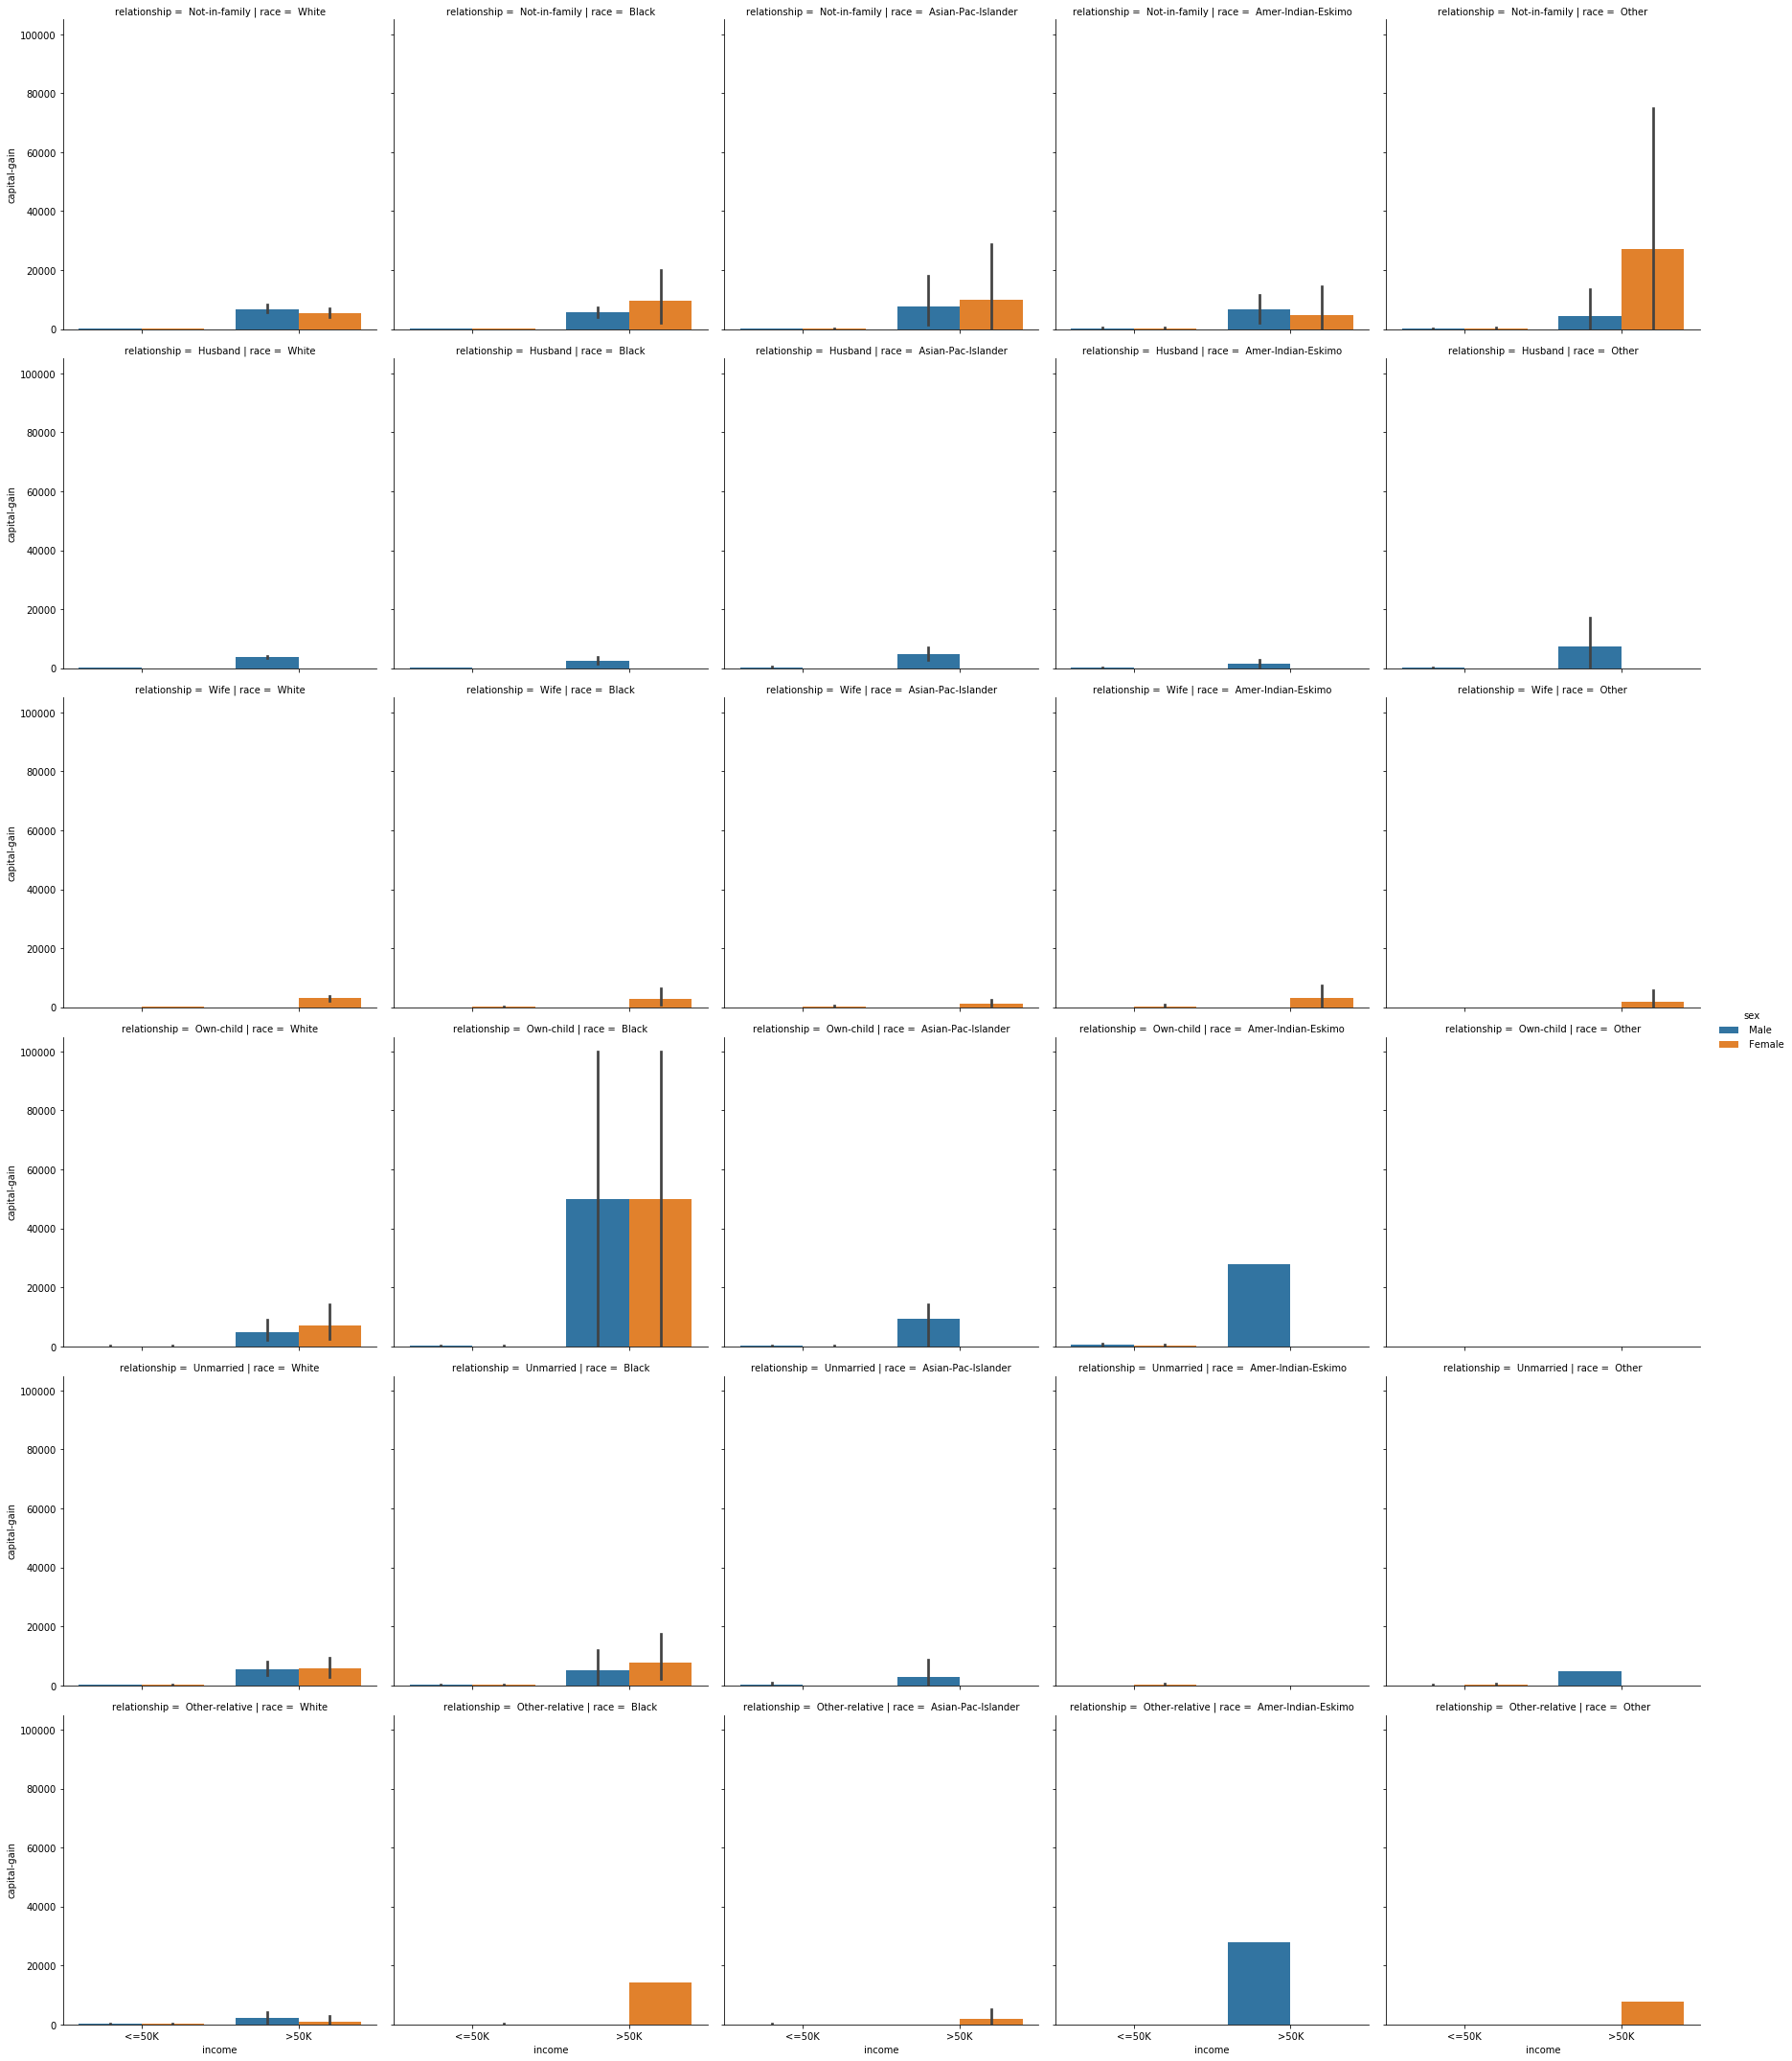

In [3]:
# visualize features of the data
sn.catplot(x='income', y='capital-gain', hue='sex', data = data,
              kind='bar', col='race', row='relationship',
              legend=True);

## Prepare the Data

In this part, I'm going to preprocess the data. Fortunately, for this dataset, there're no invalid or missing entries to deal with. However, there're some qualities about certain features that must be adjusted.

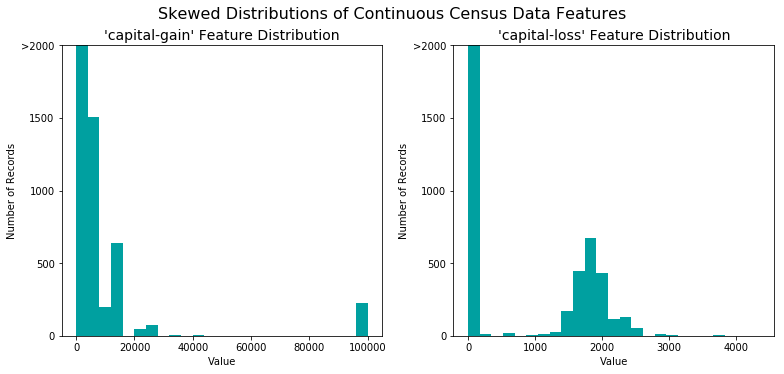

In [4]:
# split data into features and target label
income_raw = data['income']
features_raw = data.drop('income', axis=1)

# visualize skewed continuous features of original data
vs.distribution(data)

`'capital-gain'` and `'capital-loss'` are highly skewed features. A logarithmic transformation is going to significantly reduce the range of values. 

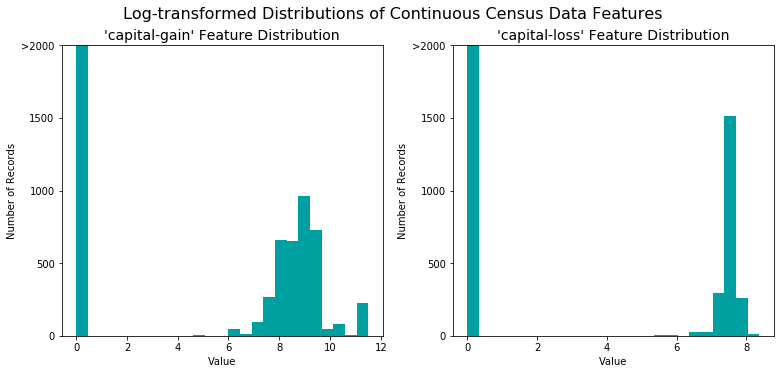

In [5]:
# log-transfrom the skewed features
skewed = ['capital-gain', 'capital-loss']
features_log_transformed = pd.DataFrame(data = features_raw)
features_log_transformed[skewed] = features_raw[skewed].apply(lambda x: np.log(x + 1))

# visualize the new log distributions
vs.distribution(features_log_transformed, transformed=True)

In addition to performing transformations on features that are highly skewed, it's good to perform some type of scaling. This will ensure that each feature is treated equally when applying supervised learners.

In [6]:
# import scaler
from sklearn.preprocessing import MinMaxScaler

# initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

features_log_minmax_transformed = pd.DataFrame(data = features_log_transformed)
features_log_minmax_transformed[numerical] = scaler.fit_transform(features_log_minmax_transformed[numerical])

# show some results of scaling
display(features_log_minmax_transformed.head(5))

/Users/dmitrykrasnikov/anaconda3/envs/ds/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.301370,State-gov,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,0.667492,0.0,0.397959,United-States
1,0.452055,Self-emp-not-inc,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000000,0.0,0.122449,United-States
2,0.287671,Private,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.000000,0.0,0.397959,United-States
3,0.493151,Private,11th,0.400000,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.000000,0.0,0.397959,United-States
4,0.150685,Private,Bachelors,0.800000,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.000000,0.0,0.397959,Cuba


There're several features for each record that are non-numeric. These categorical features need to be converted using the one-hot encoding scheme.

Additionally, the non-numeric target label `'income'` needs to be converted to numeric values.

In [7]:
# import encoder
from sklearn.preprocessing import LabelEncoder

# one-hot encode features
features_final = pd.get_dummies(features_log_minmax_transformed)

# encode target label to numerical values
le = LabelEncoder()
income = le.fit_transform(income_raw)

# print number of features after one-hot encoding
encoded = list(features_final.columns)
print('{} total features after one-hot encoding'.format(len(encoded)))

# see encoded features
# print(encoded)

103 total features after one-hot encoding


Now I'm going to split data into training and test sets. 80% of data for training and 20% for testing.

In [8]:
# import splitter
from sklearn.model_selection import train_test_split

# split features and target into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_final, income,
                                                    test_size = 0.2,
                                                    random_state = 1)
# show results of the split
print('Testing set has {} samples'.format(X_train.shape[0]))
print('Testing set has {} samples'.format(X_test.shape[0]))

Testing set has 36177 samples
Testing set has 9045 samples


## Evaluate Model Performance

In this part, I'm going to investigate four different algorithms and determine which is best at modeling data. Three of these algorithms are going to be supervised learners and the fourth algorithm is going to be a naive predictor.

### Metrics

CharityML is looking to find individuals willing to donate. It would be more important to preddict people who make more than \\$50,000 accurately as opposed to just making accurate predictions for both categories of more than \\$50,000 and at most \\$50,000. Therefore, a model's goal needs to be ability to precisely predict those that make more than \\$50,000. I'm going to use F-beta score as a metric that considers both precision and recall:

$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$

I'll use $\beta = 0.5$, to put more emphasis on precision. 

### Naive Predictor Performance

The purpose of this predictor is to show what a base model without any intelligence would look like. This predictor will always predict that an individual makes more than \\$50,000. It can't be predicting otherwise because then CharityML would have nobody to ask for donations.

In [9]:
# calculate accuracy, precision and recall
accuracy = income.sum()/income.shape[0]
recall = 1
precision = income.sum()/income.shape[0]

# calculate F-score
beta = 0.5
fscore = (1 + np.square(beta)) * precision * recall / \
            (np.square(beta) * precision + recall)

# print results 
print('Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]'.\
      format(accuracy, fscore))


Naive Predictor: [Accuracy score: 0.2478, F-score: 0.2917]


### Supervised Learning Models

**1. Random Forest** <br>
- There're several strengths in this approach. First, decision trees help us find structure in data. Second, decision trees are very flexible models, but it's easy to overfit. Bagging decision trees and averaging results would help us reduce variance. Third, in data, some features can be more dominant than others. This can lead to similar structure in every decision tree, if we're bagging them together. This scenario would not be effective in reducing variance. Avoiding this problem is the strength of random forest approach. 
- One weakness is that when we use more than one decision tree, interpretability of the model is extremely difficult.
- This model is a good candidate because we want the model to group people into those who earn more than 50k and those who don't. Decision trees are good at grouping things. Also, we're using the random forest approach to generalize to new data.

**2. AdaBoost** <br>
- AdaBoost's strength is that, with each consecutive learner it creates, it focuses on areas where algorithm is not performing well so far.
- Its weakness is that it can be sensitive to outliers and noisy data.
- This model is a good candidate because it places a stronger focus on data are points that are difficult to classify.

**3. Logistic Regression** <br>
- Its strength is its interpretability and simplicity.
- Its weakness is that it will not perform well if relationships are not linear. In that case, the model would be not flexible enough and would have high error due to bias.
- This model is a good candidate because of its simplicity. There're a lot of input features in the problem and I suspect that not all of them are relevant in predicting if a person makes more than 50K. With logistic regression we can use a back-selection approach to remove variables that are not significant in predicting a response (high p-value). 

In [10]:
# import metrics
from sklearn.metrics import fbeta_score, accuracy_score

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test):
    '''
    inputs:
        - learner: the learning algorithm to be trained and predicted on
        - sample_size: the size of samples (number) to be drawn from training set
        - X_train: features training set
        - y_train: income training set
        - X_test: features testing set
        - y_test: income testing set
    '''
    
    results = {}
    
    # fit learner to training data
    start = time() # get start time
    learner.fit(X_train.iloc[:sample_size,:], y_train[:sample_size])
    end = time() # get end time
    
    # calculate training time
    results['train_time'] = end - start
    
    # get predictions on test set and first 300 training samples
    start = time() # get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train.iloc[:300,:])
    end = time() # get end time
    
    # calculate prediction time
    results['pred_time'] = end - start
    
    # calculate accuracy on first 300 training samples
    results['acc_train'] = accuracy_score(y_train[:300], predictions_train)
    
    # compute accuracy on test set
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    # compute F-score on first 300 training samples
    results['f_train'] = fbeta_score(y_train[:300], predictions_train, beta=0.5)
    
    # compute F-score on test set
    results['f_test'] = fbeta_score(y_test, predictions_test, beta=0.5)
    
    # return results
    return results

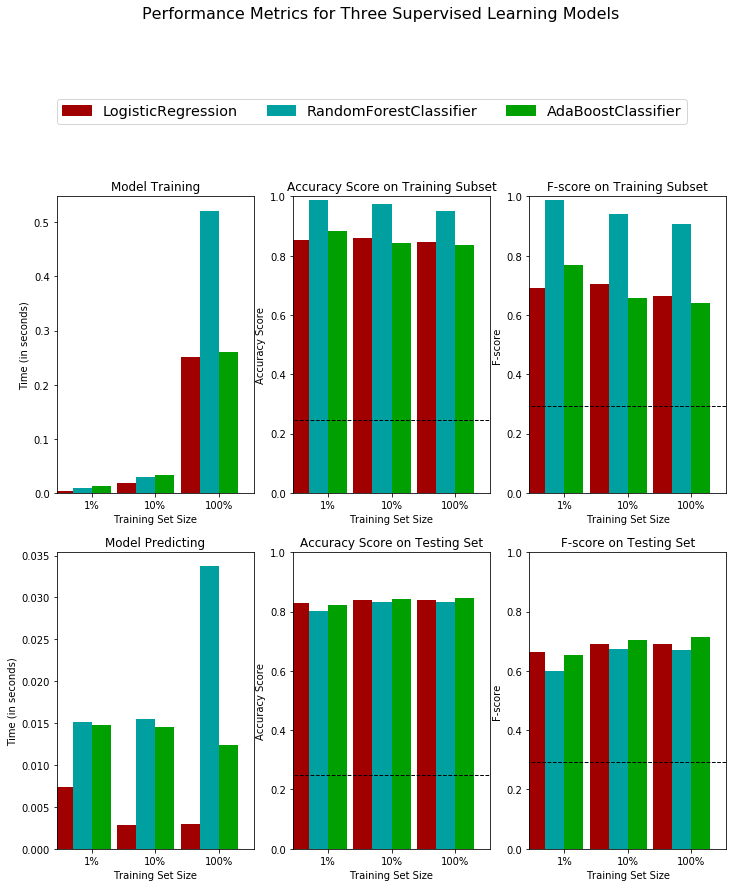

In [27]:
# import the supervised learning models
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression

# initialize three models
clf_A = LogisticRegression(solver='liblinear', random_state = 1)
clf_B = RandomForestClassifier(n_estimators=10, random_state = 1)
clf_C = AdaBoostClassifier(n_estimators=10, learning_rate=1.0, random_state = 1)

# calculate number of samples for 1%, 10%, and 100% of the training data
samples_100 = len(y_train)
samples_10 = int(samples_100*0.10)
samples_1 = int(samples_100*0.01)

# collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)
        
# run metric visualization for the models
vs.evaluate(results, accuracy, fscore)

In [41]:
for i in results.items():
    print(i[0])
    display(pd.DataFrame(i[1]).rename(columns={0:'1% of train', 
                                                1:'10% of train',
                                                2: '100% of train'}))

LogisticRegression


,1% of train,10% of train,100% of train
acc_test,0.827971,0.838143,0.840685
acc_train,0.853333,0.860000,0.846667
f_test,0.665194,0.689079,0.690930
f_train,0.692308,0.704225,0.663580
pred_time,0.007364,0.002821,0.003005
train_time,0.002865,0.018433,0.251462


RandomForestClassifier


,1% of train,10% of train,100% of train
acc_test,0.803648,0.832725,0.832946
acc_train,0.986667,0.973333,0.950000
f_test,0.600644,0.674194,0.671168
f_train,0.987654,0.941176,0.906250
pred_time,0.015189,0.015489,0.033702
train_time,0.009835,0.030220,0.521759


AdaBoostClassifier


,1% of train,10% of train,100% of train
acc_test,0.823881,0.843892,0.846656
acc_train,0.883333,0.843333,0.836667
f_test,0.653781,0.704903,0.714787
f_train,0.767857,0.658784,0.642361
pred_time,0.014768,0.014517,0.012424
train_time,0.012670,0.032948,0.260170


**AdaBoost** <br>
I believe AdaBoost classifier is the best for the of identifying individuals who make more than 50k. It's performance on test set is improving with increase in training size. This improvement is slightly better than the other classifiers. Also, the time to train and predict is small for all chosen classifiers. 

**AdaBoost Classifier Description** <br>
AdaBoost technique combines multiple "weak learners" into a single "strong learner". A weak classifier is simply a classifier that performs poorly, but better than random guessing. The idea is to set weights to both classifiers (all week classifiers) and data points (updated through training) in a way that forces classifiers to concentrate on observations that are difficult to correctly classify. This process is done sequentially in that the two weights are adjusted at each step as iterations of the algorithm proceed. For predictions, the results from weak learners are combined, based on their assigned weight, into one answer. AdaBoost can be applied to any classification algorithm, so it's really a technique that builds on top of other classifiers as opposed to being a classifier itself.

### Model Tuning

In [46]:
# import libraries for optimization
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, roc_auc_score

# initialize the classifier
clf = AdaBoostClassifier(random_state=1)

# parameters to tune
parameters = {'n_estimators': [10, 300, 600]}

# make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta=0.5)

# create grid search object
grid_obj = GridSearchCV(clf, parameters, scoring=scorer, cv=3)

# fit grid search object to training data and get the optimal parameters
grid_fit = grid_obj.fit(X_train, y_train)

# get the estimator
best_clf = grid_fit.best_estimator_

# make predictions using unoptimized and optimized models
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print('Unoptimized model\n------')
print('Accuracy score on testing data: {:.4f}'.format(accuracy_score(y_test, predictions)))
print('F-score on testing data: {:.4f}'.format(fbeta_score(y_test, predictions, beta = 0.5)))
print('AUC score on testing data: {:.4f}'.format(roc_auc_score(y_test, predictions)))
print('\nOptimized Model\n------')
print('Final accuracy score on the testing data: {:.4f}'.format(accuracy_score(y_test, best_predictions)))
print('Final F-score on the testing data: {:.4f}'.format(fbeta_score(y_test, best_predictions, beta = 0.5)))
print('AUC score on testing data: {:.4f}'.format(roc_auc_score(y_test, best_predictions)))

Unoptimized model
------
Accuracy score on testing data: 0.8566
F-score on testing data: 0.7313
AUC score on testing data: 0.7726

Optimized Model
------
Final accuracy score on the testing data: 0.8669
Final F-score on the testing data: 0.7509
AUC score on testing data: 0.7936
